In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams["font.size"] = 11

file_path = '../results/MoE.csv'

x_dict = {'4096_14336_8': 'Mixtral-8x7B', 
        '2304_5760_8': 'MiniCPM-MoE', 
        '4096_11008_8': 'MiniCPM',
        '6144_16384_8': 'Mixtral-8x22B', 
        '2048_8192_32': 'OpenMoE-8B',
        '3072_12288_32': 'OpenMoE-34B',
        '2048_1408_64': 'DeepSeek-MoE',
        '2048_1408_60': 'Qwen2-MoE'
        }

order = ['MiniCPM-MoE', 'OpenMoE-34B', 'Mixtral-8x7B', 'Mixtral-8x22B', 'Qwen2-MoE', 'DeepSeek-MoE']

df = pd.read_csv(file_path)

In [2]:
def select_data(df, model_name, batch_size_list, para_lists=[(4096,14336,8), (2304,5760,8), (6144,16384,8), (2048,8192,32), (3072,12288,32), (2048,1408,64), (2048,1408,60)]):
    data = {}

    for index, row in df.iterrows():
        batch_size = row['batch_size']
        hidden_size = row['hidden_size']
        intermediate_size = row['intermediate_size']
        kernel_type = row['kernel type']
        time = row['time']
        name = row['model']
        expert_num = row['expert_num']
        
        if name != model_name:
            continue
        if batch_size not in batch_size_list:
            continue
        if (hidden_size, intermediate_size, expert_num) not in para_lists:
            continue

        name = f"{hidden_size}_{intermediate_size}_{expert_num}"

        if name not in data:
            data[name] = {'GEMM': 0, 'megablocks': 0, 'vLLM': 0, 'Samoyeds': 0}

        if kernel_type == 'GEMM':
            data[name]['GEMM'] = time
        elif kernel_type == 'vLLM':
            data[name]['vLLM'] = time
        elif kernel_type == 'Samoyeds':
            data[name]['Samoyeds'] = time
        elif kernel_type == 'megablocks':
            data[name]['megablocks'] = time

    data_array = [[x_dict[name]] + list(values.values()) for name, values in data.items()]
    
    return data_array

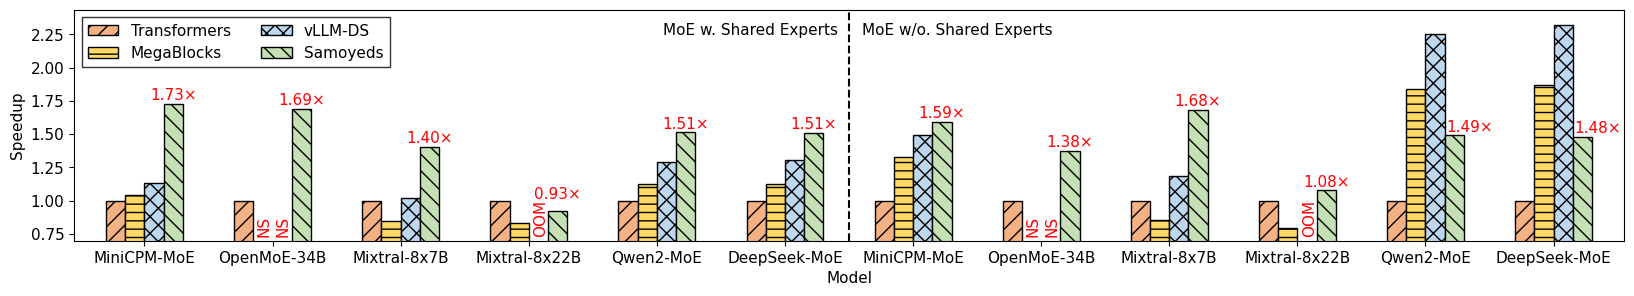

In [3]:

mixtral_data_array = select_data(df, 'Mixtral', batch_size_list=[1,16,14], para_lists=[(4096,14336,8), (2304,5760,8), (6144,16384,8), (2048,8192,32), (3072,12288,32), (2048,1408,64), (2048,1408,60)])

mixtral_data_df = pd.DataFrame(mixtral_data_array, columns=['name', 'GEMM', 'megablocks', 'vLLM', 'Samoyeds'])

mixtral_data_df.set_index('name', inplace=True)
mixtral_data_df = mixtral_data_df.loc[order]

deepseek_data_array = select_data(df, 'DeepSeek', batch_size_list=[1,16,14], para_lists=[(4096,14336,8), (2304,5760,8), (6144,16384,8), (2048,8192,32), (3072,12288,32), (2048,1408,64), (2048,1408,60)])

deepseek_data_df = pd.DataFrame(deepseek_data_array, columns=['name', 'GEMM', 'megablocks', 'vLLM', 'Samoyeds'])

deepseek_data_df.set_index('name', inplace=True)
deepseek_data_df = deepseek_data_df.loc[order]

data_df = pd.concat([deepseek_data_df, mixtral_data_df], ignore_index=False)

data_df['vLLM'] = data_df['GEMM'] / data_df['vLLM'] 
data_df['Samoyeds'] = data_df['GEMM'] / data_df['Samoyeds']
data_df['megablocks'] = data_df['GEMM'] / data_df['megablocks']
data_df['GEMM'] = data_df['GEMM'] / data_df['GEMM']

data_df.rename(columns={'GEMM': 'Transformers', 'megablocks': 'MegaBlocks', 'vLLM': 'vLLM-DS', 'Samoyeds': 'Samoyeds'}, inplace=True)

colors = ['#F4B183', '#FFD966', '#BDD7EE', '#C5E0B4']
ax = data_df.plot.bar(rot=0, figsize=(20,3), width=0.6, color=colors, edgecolor='black')

hatches = ['//', '--', 'xx', '\\\\']
color_to_hatch = dict(zip(colors, hatches))
for i, bar in enumerate(ax.patches):
    hex_color = mcolors.to_hex(bar.get_facecolor()).upper()
    bar.set_hatch(color_to_hatch[hex_color])
    
    if i/data_df.shape[0] >= 3:
        if i == 39:
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.09, f'{bar.get_height():.2f}\u00D7', ha='center', color='red')
        elif i == 46 or i == 47:
            ax.text(bar.get_x()+0.01, bar.get_height()+0.03, f'{bar.get_height():.2f}\u00D7', ha='left', color='red')
        else:
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.03, f'{bar.get_height():.2f}\u00D7', ha='center', color='red')

ax.axvline(x=len(mixtral_data_array)-1.5, linestyle='--', color='black')
ax.text(len(mixtral_data_array)-2.95, 2.25, 'MoE w. Shared Experts', ha='left')
ax.text(len(mixtral_data_array)-1.4, 2.25, 'MoE w/o. Shared Experts', ha='left')

# OpenMoE no supported
ax.text((ax.patches[13].get_x() + ax.patches[25].get_x())/2+0.01, 0.75, 'NS', ha='center', rotation=90, color='red')
ax.text((ax.patches[25].get_x() + ax.patches[37].get_x())/2+0.01, 0.75, 'NS', ha='center', rotation=90, color='red')
ax.text((ax.patches[19].get_x() + ax.patches[31].get_x())/2+0.01, 0.75, 'NS', ha='center', rotation=90, color='red')
ax.text((ax.patches[31].get_x() + ax.patches[43].get_x())/2+0.01, 0.75, 'NS', ha='center', rotation=90, color='red')

# OOM
ax.text((ax.patches[27].get_x() + ax.patches[39].get_x())/2+0.02, 0.75, 'OOM', ha='center', rotation=90, color='red')
ax.text((ax.patches[33].get_x() + ax.patches[45].get_x())/2+0.02, 0.75, 'OOM', ha='center', rotation=90, color='red')

ax.set_ylim([0.7, ax.get_ylim()[1]])

legend = ax.legend(loc='upper left', ncol=2, frameon=True, fancybox=False)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_facecolor('none')

ax.set_xlabel("Model")
ax.set_ylabel("Speedup")

plt.show()